# Barlow Twins

In this session we are going to implement Barlow Twins paper (https://arxiv.org/abs/2103.03230).

It follows the same batch construction as SimCLR. The loss is:
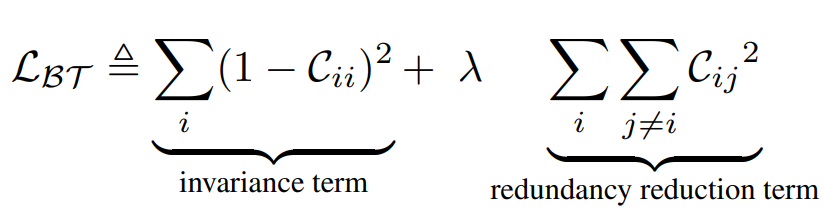



# 1. the model wants to be invariant to augmentations, 2 augmentations of the same image should produce the same representation
# 2. representation collapse-free, to this end it tries to disentngle the dimensions of the representation to the encode different info

di base lavoro su matrice di cross correlazione, ogni elemento della matrice mi dice la similitudine tra coppie di imgs

so dove sono le positive pair, voglio che la rappresentazione massimizzi similitudine ancher positive e minimizzi tutte le altre similitudine che sono off-diagonal
Idealmente voglio ottenere una matrice simile all'identità, ma non è nemmeno troppo desiderabile, negative sample potrebbe essere un'altro gatto, voglio imparare rappresentazione invariante a rappresentazione così che quando vooglio adattare traformazione appresa, parto da rappresentazione molto potente e la head può performare meglio.

la matrice di correlazione tende ad essere troppo frossa, allora usa vicreg e fanno 3 loss che fanno la stessa cosa, così evito calcolo matrice di covarianza

In [27]:
import os
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from torchvision.io import read_image

import torchvision
import torchvision.models as models
import torchvision.transforms as transforms

from PIL import Image

In [28]:
# Custom Dataset class
class CustomImageDataset(Dataset):
    def __init__(self, data, targets=None, transform=None, target_transform=None):
        self.imgs = data # Tensore di tutte le immagini
        self.targets = targets
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img = self.imgs[idx] # Sampling randomico di emlementi del dataset
        if isinstance(img, str): # Può capitare che il dataset sia salvato come stringhe/path (da usare quando non è possibile salvarsi tutto il tensore del dataset)
          img = read_image(img_path) # Fuzione di Torchvision, trova un'immaigne dal path fornito
        else:
          img = Image.fromarray(img.astype('uint8'), 'RGB') # Preso un array restituisce un'immagine RGB, senza non si riesce a lavorare
        if self.targets:
          label = self.targets[idx] # Non utile nel caso di self-supervised ovviamente
        if self.transform:
          img1 = self.transform(img) # Utilizzo le trasformazioni
          img2 = self.transform(img)  # Già così genero due immagini augmented diverse, siccome le funzioni che trasformano sono randomiche (TODO, rivedi le variabili)
        if self.target_transform:
          label1 = self.target_transform(label)
          label2 = self.target_transform(label)
        return img1, img2 #, label # Concateno immaigni e labels

# Simmetric Siamese
class SiameseNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = models.resnet18()
        self.backbone.fc = nn.Identity()


    def forward(self, x1, x2):
        # buona pratica, concatenare x1 e x2 in un unico tensore
        x1 = self.backbone(x1)
        x2 = self.backbone(x2)
        return x1,x2 # concatena x1 e x2

In [ ]:
def off_diagonal(x):
    # return a flattened view of the off-diagonal elements of a square matrix
    n, m = x.shape
    assert n == m
    return x.flatten()[:-1].view(n - 1, n + 1)[:, 1:].flatten()


class BarlowTwinsLoss(nn.Module):
    def __init__(self, lambd):
        super().__init__()
        self.lambd = lambd

        # barlow twin projector
        sizes = [512, 2048] # in the paper is [2048, 8192, 8192, 8192]
        layers = []
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i + 1], bias=False))# occhio a quali parametri passi, ottimizzatore deve avere parametri sia siamese sia mlp
            layers.append(nn.BatchNorm1d(sizes[i + 1]))
            layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Linear(sizes[-2], sizes[-1], bias=False))
        self.projector = nn.Sequential(*layers)

        # normalization layer for the representations z1 and z2
        self.bn = nn.BatchNorm1d(sizes[-1], affine=False)

    def forward(self, features1, features2):
        batch_size=features1.shape[0]
        x1 = self.bn(self.projector(features1))
        x2 = self.bn(self.projector(features2))
        x1=F.normalize(x1,dim=1)
        x2=F.normalize(x2,dim=1)

        # Compute the cross-correlation matrix
        cross_corr_matrix = torch.matmul(x1, x2.T)

        # Extract the diagonal elements
        diagonal_elements = torch.diag(cross_corr_matrix)
        print('diagonal',diagonal_elements)
        diagonal_elements = 1-diagonal_elements
        print(diagonal_elements)
        # Square the diagonal elements
        squared_diagonal_elements = torch.square(diagonal_elements)
        # Sum the squared diagonal elements
        invariance = torch.sum(squared_diagonal_elements)

        #prof version
        invariance = torch.diagonal(cross_corr_matrix).add_(-1).pow_(2).sum()# queste con _ alla fine QUESTA QUI è UN OPERAZIONE INPLACE!!!!!!!!!!!!!!!!! usamiiii
        redundancy_reduction = off_diagonal(cross_corr_matrix).pow_(2).sum()

        # Print the result
        #print("Sum of squared diagonal elements:", invariance.item())

        redundancy_reduction = torch.sum(torch.square(off_diagonal(cross_corr_matrix)))

        loss = invariance + self.lambd * redundancy_reduction# calcola invariance e redundancy_reduction
        return loss

In [30]:
s=1
size=32
color_jitter = transforms.ColorJitter(0.8 * s, 0.8 * s, 0.8 * s, 0.2 * s)
transform = transforms.Compose([transforms.RandomResizedCrop(size=size),
                                  transforms.RandomHorizontalFlip(),
                                  transforms.RandomApply([color_jitter], p=0.8),
                                  transforms.RandomGrayscale(p=0.2),
                                  transforms.GaussianBlur(kernel_size=3),
                                  transforms.ToTensor()])
data = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)   
trainset = CustomImageDataset(data.data, data.targets, transform=transform)
dataloader = DataLoader(trainset, batch_size=64, shuffle=True)

model = SiameseNet()# impot me!, la vuoole simmetrica come su simCLR


Files already downloaded and verified


In [ ]:
criterion = BarlowTwinsLoss(0.005)
criterion_params = {'params': criterion.projector.parameters()}# c'è anche batch norm???
# definisci tutti i parametri dentro la classe
model_params = {'params': model.parameters()}


optimizer = torch.optim.Adam([criterion_params, model_params], lr=0.04, weight_decay = 1e-04)



for idx, data in enumerate(dataloader):
    x1, x2 = data
    #print(x1.shape)
    #print(x2.shape)

    optimizer.zero_grad()
    output1, output2 = model(x1,x2)
    loss = criterion(output1, output2)
    print(loss)
    loss.backward()
    optimizer.step()
    

    if idx == 3:
        break

diagonal tensor([  65.9346,  270.4793, -331.6493,  879.1371, -314.5082, -316.9139,
         151.4806,   27.8820,  114.3391,  224.4271, -341.0258,   63.5273,
         165.3993,   22.5184,  173.7431,  291.6211, -546.1589, -738.6162,
         136.0674, -767.4334,   95.8032,   51.9295, -403.4327, 2692.4280,
        -385.8885,  -61.7282, -195.8858, -497.5417,  235.1269,   12.1576,
        -206.3681,  109.2375,  178.5761,  267.6139,  207.7764,   89.8470,
        -263.0571,  110.3790,  213.1267, -234.3802,  746.1296,    7.7659,
         136.0892, -254.2917,  229.6070,  178.5107, 1141.1051, -191.8012,
         119.3304, -371.7017,  169.5523,  135.4621,   55.5593,  -91.8279,
         265.8223,  156.4308,   26.1631,  108.7843, -190.3760,  212.1308,
         -74.9275,  218.5475, -359.4812,   69.9391],
       grad_fn=<DiagonalBackward0_copy>)
tensor([  -64.9346,  -269.4793,   332.6493,  -878.1371,   315.5082,   317.9139,
         -150.4806,   -26.8820,  -113.3391,  -223.4271,   342.0258,   -62.527